## Plot Results

In [54]:
import pickle
import matplotlib
import matplotlib.pyplot as plt

results = {}

with open("results/small_flow_correlations.pkl", "rb") as f:
    results["small"] = pickle.load(f)

with open("results/sdc_flow_correlations.pkl", "rb") as f:
    results["sdc"] = pickle.load(f)

In [ ]:
def plot_results(results, ax, title, xlabel=False, ylabel=False, legend=False):
    ax.plot(results["greedy"].keys(), results["greedy"].values(), "b", label="Greedy",
           linewidth=3)
    ax.plot(results["rrqr"].keys(), results["rrqr"].values(), "r", label="RRQR",
           linewidth=3)
    ax.plot(results["random"].keys(), results["random"].values(), "m", label="Random",
           linewidth=3, linestyle="dashed")
    
    if results["rb"]:
        ax.plot(results["rb"].keys(), results["rb"].values(), "g", label="RB",
           linewidth=3)
    
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Number of Sensors (%)", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)

matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_results(results["small"], ax[0][0], "LA (Small)", ylabel=True, legend=True)
plot_results(results["sdc"], ax[0][1], "San Diego")
plt.savefig("results/traffic_correlations.pdf")

## Some Theory

In [30]:
import networkx as nx
import scipy.linalg as linalg
from sensors import utils, flows
import numpy as np

G, labeled_flows = utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp")
evaluator = flows.lazy.LazyEvaluator(G, labeled_flows)
evaluator.al_flows_greedy(1)

100%|███████████████████████████████████████████████████████████████| 914/914 [00:09<00:00, 98.16it/s]


[(63, 62),
 (4, 233),
 (143, 142),
 (1, 117),
 (195, 194),
 (133, 132),
 (92, 91),
 (167, 166),
 (204, 203),
 (215, 214),
 (182, 181),
 (76, 75),
 (211, 210),
 (139, 138),
 (129, 128),
 (200, 199),
 (106, 105),
 (66, 65),
 (148, 147),
 (245, 244),
 (237, 236),
 (121, 120),
 (222, 221),
 (239, 238),
 (174, 173),
 (80, 79),
 (78, 77),
 (169, 168),
 (150, 149),
 (158, 157),
 (192, 191),
 (178, 177),
 (226, 225),
 (98, 97),
 (112, 111),
 (104, 103),
 (219, 218),
 (131, 130),
 (207, 206),
 (87, 86),
 (124, 123),
 (202, 201),
 (241, 240),
 (68, 67),
 (176, 175),
 (144, 143),
 (165, 164),
 (110, 109),
 (163, 162),
 (25, 268),
 (126, 125),
 (180, 179),
 (247, 246),
 (118, 5),
 (228, 227),
 (153, 152),
 (199, 198),
 (209, 208),
 (224, 223),
 (203, 202),
 (25, 269),
 (140, 139),
 (249, 248),
 (107, 106),
 (243, 242),
 (156, 155),
 (253, 252),
 (196, 195),
 (99, 98),
 (400, 399),
 (123, 122),
 (407, 408),
 (146, 145),
 (70, 69),
 (135, 134),
 (90, 89),
 (127, 126),
 (116, 115),
 (34, 369),
 (105,

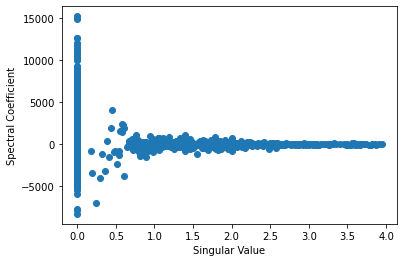

In [98]:
def plot_spectral_coefs(G, flow):
    n, m = G.number_of_nodes(), G.number_of_edges()

    B = nx.incidence_matrix(G, oriented=True).toarray()
    U, s, Vh = linalg.svd(B)
    Sigma = linalg.diagsvd(s, U.shape[1], Vh.shape[0])

    plt.scatter(list(s) + [0] * (m - n), Vh @ utils.metrics.dict2vect(G, flow))
    plt.xlabel("Singular Value")
    plt.ylabel("Spectral Coefficient")
    
    return U, Sigma, Vh.T
    
U, Sigma, V = plot_spectral_coefs(G, labeled_flows)

In [113]:
f = utils.metrics.dict2vect(G, labeled_flows)
p = V.T @ f

S = [list(G.edges()).index(e) for e in evaluator.sensors[:10]]
c = G.number_of_edges() - G.number_of_nodes() + 1
V_C = V[:, c:]

In [114]:
V_R = V[:, :c]
V_SC = V_C[np.ix_(S)]
np.linalg.norm(V_R.T @ f) / np.linalg.norm(V_C.T @ f) 

0.5921407019655196

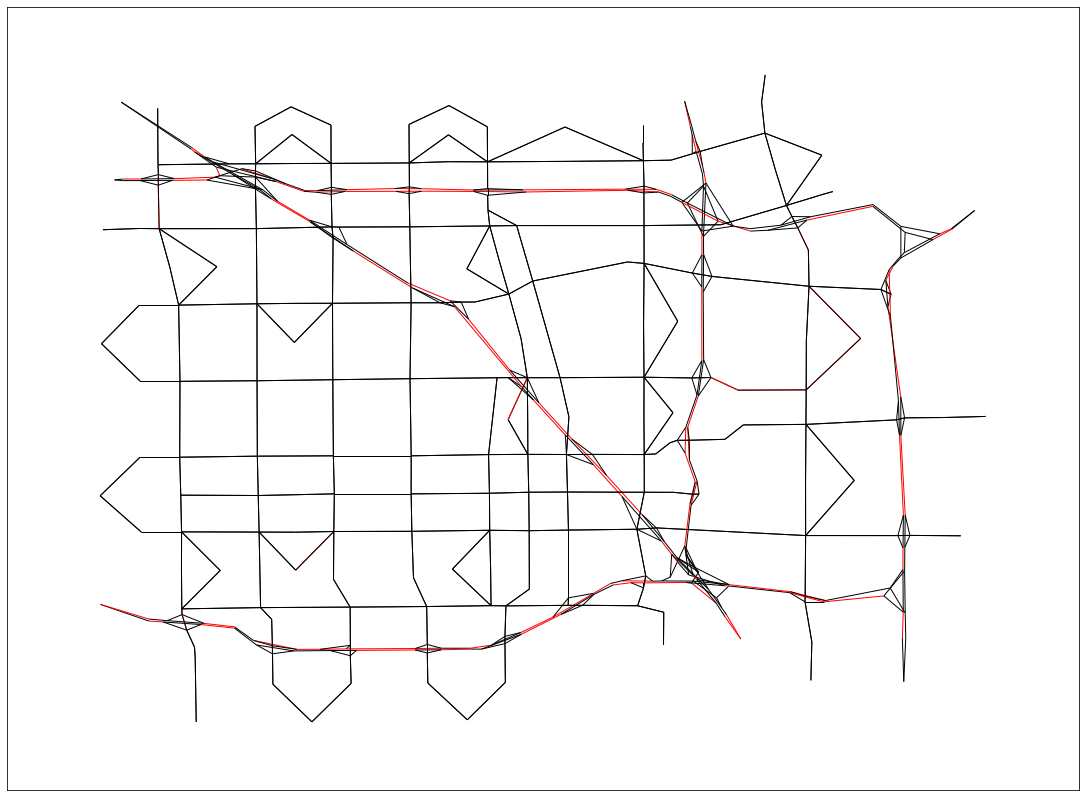

In [146]:
import json

with open("data/Anaheim/anaheim_nodes.geojson") as f:
    features = json.loads(f.read())["features"]

coords = {}
for feat in features:
    coords[feat["properties"]["id"]] = feat["geometry"]["coordinates"]

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G, coords, 
        edge_color=["red" if e in evaluator.sensors[:100] else "black" for e in G.edges()],
        arrows=False)

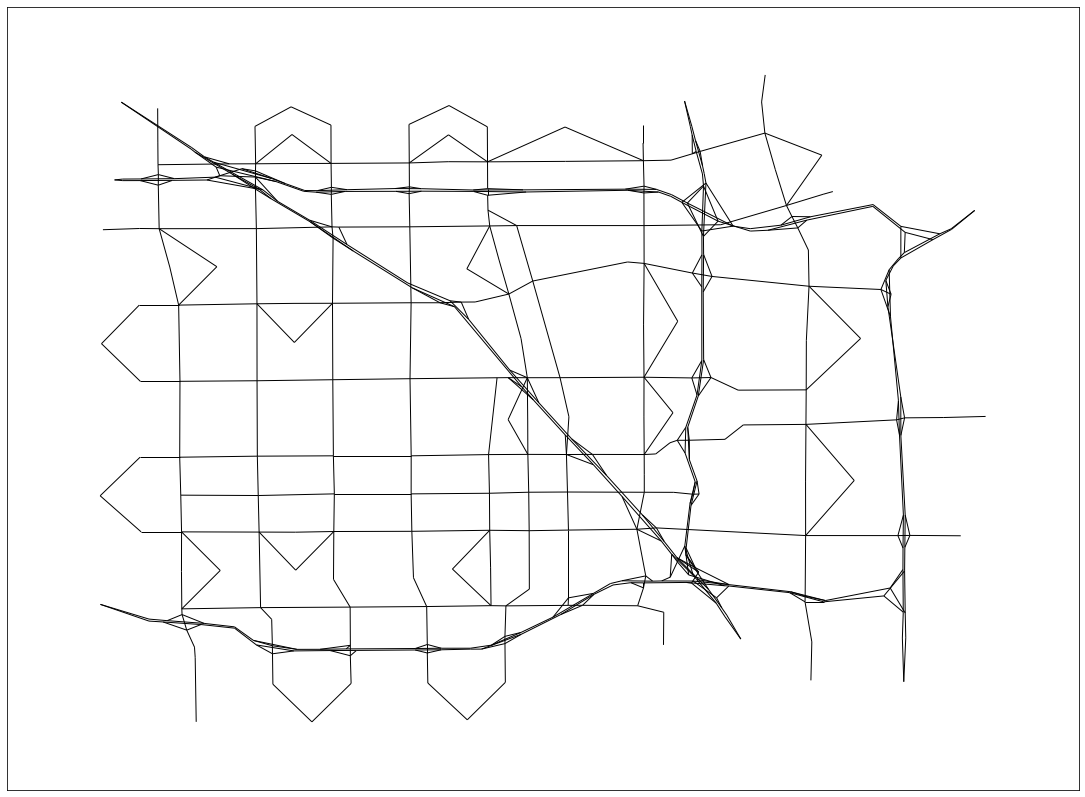

In [150]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G.to_undirected(), coords,
        arrows=False)